<a href="https://colab.research.google.com/github/csabi0312/crypto-svm/blob/gru/crypto14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.5 MB/s eta 0:00:00


In [3]:
pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install oandapyV20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=70035 sha256=cb1f83dce0cc73e4f82797f60ede7037fbf1f12cb0a51eece9a284904b24877b
  Stored in directory: /root/.cache/pip/wheels/d2/b6/8e/6fe7d26410a99ddb24ac4358691c5feabf4320d20d8053ca25
Successfully built oandapyV20


In [5]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.4 MB/s eta 0:00:00


In [6]:
pip install v20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for v20: filename=v20-3.0.25.0-py3-none-any.whl size=85780 sha256=b87cdbabea222fd86f003825c99bc03157fd94de90559c940486844eb0e15f86
  Stored in directory: /root/.cache/pip/wheels/9b/50/e6/7431cad84aed36618f1cd68ee913ba2d8b7759e3c4aecfe2d5
Successfully built v20


In [7]:
pip install --upgrade git+https://github.com/yhilpisch/tpqoa.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/yhilpisch/tpqoa.git to /tmp/pip-req-build-s5mj628w
  Running command git clone --filter=blob:none --quiet https://github.com/yhilpisch/tpqoa.git /tmp/pip-req-build-s5mj628w
  Resolved https://github.com/yhilpisch/tpqoa.git to commit f47a1ffddd2b2684c7e1569df6210b98dbe4e701
  Preparing metadata (setup.py) ... done
  Created wheel for tpqoa: filename=tpqoa-0.0.55-py3-none-any.whl size=10928 sha256=c1eebb7633bff13110ca67712324c592c2d68987476eea58a4aff9c6b7f5ce12
  Stored in directory: /tmp/pip-ephem-wheel-cache-ylkyiziz/wheels/54/90/ca/b84ec93e1d9679237c36be01b355ed94b670276656689e84a5
Successfully built tpqoa


In [8]:
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from numpy import trapz
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from numpy import trapz
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras.losses
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner
import tpqoa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
import oandapyV20.endpoints.instruments as instruments
import datetime
import oandapyV20.endpoints.instruments as instruments
import datetime
from sklearn.metrics import mean_squared_error as mse

In [9]:
pip install rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1


In [10]:
from rich.progress import track

# DATA

In [12]:
raw = pd.read_csv("/content/drive/MyDrive/Crypto/new3/full_spread_data.csv", parse_dates = ["time"], index_col = "time").dropna()
#raw["returns"] =np.log(raw.Close / raw.Close.shift(1))
raw.drop(["Open","Spread"],axis=1,inplace=True)
cols = []
for lag in range(1, 40):
    col_h = "h_lag{}".format(lag)
    col_l = "l_lag{}".format(lag)
    col_c = "c_lag{}".format(lag)
    col_v = "v_lag{}".format(lag)
    raw[col_h] = raw.High.shift(lag)
    cols.append(col_h)
    raw[col_l] = raw.Low.shift(lag)
    cols.append(col_l)
    raw[col_c] = raw.Close.shift(lag)
    cols.append(col_c)
    raw[col_v] = raw.Volume.shift(lag)
    cols.append(col_v)
    raw.dropna(inplace = True)
raw.drop(["High","Low","Volume"],axis=1,inplace=True)
raw

,Close,h_lag1,l_lag1,c_lag1,v_lag1,h_lag2,l_lag2,c_lag2,v_lag2,h_lag3,...,c_lag37,v_lag37,h_lag38,l_lag38,c_lag38,v_lag38,h_lag39,l_lag39,c_lag39,v_lag39
time,,,,,,,,,,,,,,,,,,,,,
2018-02-22 22:00:00+00:00,10441.6,10400.0,9601.5,9924.3,86014.0,10934.4,9738.6,9922.6,85916.0,11751.2,...,11590.0,85728.0,11805.4,9127.5,11371.0,86148.0,13905.9,10331.5,10713.0,85728.0
2018-02-23 22:00:00+00:00,9600.2,10520.4,9924.3,10441.6,25177.0,10400.0,9601.5,9924.3,86014.0,10934.4,...,11351.7,85961.0,12108.9,10675.7,11590.0,85728.0,11805.4,9127.5,11371.0,86148.0
2018-02-24 22:00:00+00:00,10369.8,9868.7,9291.1,9600.2,60419.0,10520.4,9924.3,10441.6,25177.0,10400.0,...,12904.4,85853.0,12014.3,11052.6,11351.7,85961.0,12108.9,10675.7,11590.0,85728.0
2018-02-25 22:00:00+00:00,10293.0,10434.4,9396.2,10369.8,85554.0,9868.7,9291.1,9600.2,60419.0,10520.4,...,11363.5,75479.0,13004.7,11243.7,12904.4,85853.0,12014.3,11052.6,11351.7,85961.0
2018-02-26 22:00:00+00:00,10890.0,10399.2,10114.4,10293.0,28880.0,10434.4,9396.2,10369.8,85554.0,9868.7,...,10358.4,85958.0,12961.8,11117.0,11363.5,75479.0,13004.7,11243.7,12904.4,85853.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-17 22:00:00+00:00,20939.4,21647.9,20407.7,20773.2,517432.0,21588.4,20860.6,21314.7,424610.0,21445.4,...,16194.6,291295.0,16617.2,16343.8,16505.0,205653.0,16784.7,16453.2,16541.2,244983.0
2023-01-18 22:00:00+00:00,22330.7,21195.0,20627.2,20939.4,399542.0,21647.9,20407.7,20773.2,517432.0,21588.4,...,16463.8,265767.0,16586.4,16003.0,16194.6,291295.0,16617.2,16343.8,16505.0,205653.0
2023-01-19 22:00:00+00:00,22999.8,22439.6,20865.0,22330.7,455144.0,21195.0,20627.2,20939.4,399542.0,21647.9,...,17103.6,252757.0,16528.6,16098.6,16463.8,265767.0,16586.4,16003.0,16194.6,291295.0


In [20]:
#felso=np.quantile(raw["returns"],0.66)
#also=np.quantile(raw["returns"],0.33)
#print(felso,also)
#returns2=(raw["returns"]>felso).astype(int)+2*(raw["returns"]<also).astype(int)
#raw["returns2"]=returns2
to=int(len(raw)*0.7)
X_train=raw.drop(["Close"],axis=1).iloc[:to].to_numpy()
y_train=raw["Close"].iloc[:to].to_numpy().astype(int)
X_test=raw.drop(["Close"],axis=1).iloc[to:].to_numpy()
y_test=raw["Close"].iloc[to:].to_numpy().astype(int)

scaler1=MinMaxScaler()
X_train=scaler1.fit_transform(X_train)
X_test=scaler1.transform(X_test)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(923, 156) (923,) (396, 156) (396,)


In [33]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train=scaler1.fit_transform(X_train)
y_train=scaler2.fit_transform(y_train.reshape(-1,1)).flatten()
X_test=scaler1.transform(X_test)
y_test=scaler2.transform(y_test.reshape(-1,1)).flatten()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(923, 156) (923,) (396, 156) (396,)


# GRU

In [ ]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, 3)
#y_test = to_categorical(y_test, 3)

In [ ]:
import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [37]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(hp.Int('units', min_value=15, max_value=200, step=1),input_shape=(156,1),activation=tf.keras.layers.LeakyReLU()))
  model.add(Dropout(0.2))
  #for j in range(hp.Int('units6', min_value=1, max_value=8, step=1)):
  #  model.add(Dense(hp.Int('units10'+"_"+str(j), min_value=15, max_value=200, step=1),activation="relu"))
  #  model.add(Dropout(0.2))
  for i in range(hp.Int('units7', min_value=1, max_value=16, step=1)):
    model.add(GRU(units=hp.Int('units2', min_value=15, max_value=120, step=1), return_sequences=True, activation='tanh'))
    model.add(LSTM(units=hp.Int('units3', min_value=15, max_value=120, step=1), return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
  model.add(GRU(units=hp.Int('units2', min_value=15, max_value=120, step=1), return_sequences=False, activation='tanh'))
  #for j in range(hp.Int('units8', min_value=1, max_value=8, step=1)):
  #  model.add(Dense(hp.Int('units12'+"_"+str(j), min_value=15, max_value=200, step=1),activation="relu"))
  #  model.add(Dropout(0.2))
  model.add(Dense(hp.Int('units8', min_value=15, max_value=200, step=1),input_shape=(156,1),activation=tf.keras.layers.LeakyReLU()))
  model.add(Dense(1, activation=tf.keras.layers.LeakyReLU()))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

In [38]:
tuner = keras_tuner.RandomSearch(
      build_model,
      objective='val_loss',
      max_trials=200,overwrite = True)
tuner.search(X_train,y_train , epochs=10, validation_split=0.2)
best_model = tuner.get_best_models()[0]
best_model.summary()

Trial 200 Complete [00h 02m 02s]
val_loss: 2.887784957885742

Best val_loss So Far: 0.6948232054710388
Total elapsed time: 04h 29m 43s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 156, 128)          256       
                                                                 
 dropout (Dropout)           (None, 156, 128)          0         
                                                                 
 gru (GRU)                   (None, 156, 46)           24288     
                                                                 
 lstm (LSTM)                 (None, 156, 92)           51152     
                                                                 
 dropout_1 (Dropout)         (None, 156, 92)           0         
                                                                 
 gru_1 (GRU)                 (None, 156, 46)         

In [ ]:
def build_best():
  #hp_units = [hp.Int('units', min_value=160, max_value=320, step=1),hp.Int('units', min_value=16, max_value=120, step=1)]
  model = Sequential()
  model.add(Dense(156,input_shape=(156,1)))
  model.add(GRU(units=40, return_sequences=True, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(GRU(units=40, return_sequences=True, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(GRU(units=40, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(Dense(156))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss=f1_loss, optimizer='adam', metrics=[f1])
  return model

In [39]:
#best_model=build_best()
early_stopping=EarlyStopping(patience=100, verbose=0)
checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)
best_model.fit(X_train,y_train, batch_size=32,epochs=1000, verbose=0, \
                validation_split=0.1,callbacks=[checkpointer, early_stopping], shuffle=True)


Epoch 1: val_loss improved from inf to 1.53007, saving model to weights1.hdf5

Epoch 2: val_loss did not improve from 1.53007

Epoch 3: val_loss did not improve from 1.53007

Epoch 4: val_loss did not improve from 1.53007

Epoch 5: val_loss did not improve from 1.53007

Epoch 6: val_loss did not improve from 1.53007

Epoch 7: val_loss did not improve from 1.53007

Epoch 8: val_loss did not improve from 1.53007

Epoch 9: val_loss did not improve from 1.53007

Epoch 10: val_loss did not improve from 1.53007

Epoch 11: val_loss did not improve from 1.53007

Epoch 12: val_loss did not improve from 1.53007

Epoch 13: val_loss did not improve from 1.53007

Epoch 14: val_loss did not improve from 1.53007

Epoch 15: val_loss did not improve from 1.53007

Epoch 16: val_loss did not improve from 1.53007

Epoch 17: val_loss did not improve from 1.53007

Epoch 18: val_loss did not improve from 1.53007

Epoch 19: val_loss did not improve from 1.53007

Epoch 20: val_loss did not improve from 1.5300

In [40]:
best_model.save("/content/drive/MyDrive/Crypto/new3/best_model.h5")

In [41]:
predictions = scaler2.inverse_transform(best_model.predict(X_test)).flatten()

13/13 [==============================] - 5s 42ms/step


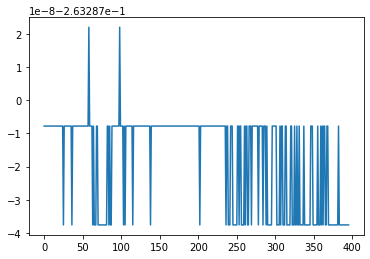

In [42]:
plt.plot(np.arange(0,len(predictions)),predictions)

In [ ]:
def plotting(predictions):
  df = pd.DataFrame(data={'Predictions':predictions,
                          'Actuals':scaler2.inverse_transform(y_test).flatten()})
  f = plt.figure(figsize=(16,16))
  ax1 = f.add_subplot()
  ax1.plot(df['Predictions_10_h'],label='Predictions_10_h')
  ax1.plot(df['Actuals_10_h'],label='Actuals_10_h')
  ax2.plot(df['Predictions_10_l'],label='Predictions_10_l')
  ax2.plot(df['Actuals_10_l'],label='Actuals_10_l')
  ax3.plot(df['Predictions_5_h'],label='Predictions_5_h')
  ax3.plot(df['Actuals_5_h'],label='Actuals_5_h')
  ax4.plot(df['Predictions_5_l'],label='Predictions_5_l')
  ax4.plot(df['Actuals_5_l'],label='Actuals_5_l')
  plt.legend()
  plt.show()
  return None

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
pred=best_model.predict(X_test)
y_pred = np.argmax(pred,1)
y_true = np.argmax(y_test,1)

print("Test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\n Confusion matrix ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

13/13 [==============================] - 5s 52ms/step
Test accuracy: 0.315657
Precision 0.10521885521885521
Recall 0.3333333333333333
f1_score 0.15994881637875877

 Confusion matrix 
[[125   0   0]
 [134   0   0]
 [137   0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
pred=best_model.predict(X_train)
y_pred = np.argmax(pred,1)
y_true = np.argmax(y_train,1)

print("Test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\n Confusion matrix ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

29/29 [==============================] - 1s 41ms/step
Test accuracy: 0.335861
Precision 0.1119537739256049
Recall 0.3333333333333333
f1_score 0.16761286834279535

 Confusion matrix 
[[310   0   0]
 [315   0   0]
 [298   0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
